# Lib

In [692]:
from typing import List
from copy import deepcopy
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import math

# Parameters

In [693]:
global u, d, r, d_r, p_tilde, q_tilde, T, S0, K, X0
global stock_price_tree, option_value_tree, hedge_tree, \
    portfolio_value_tree, consumed_tree, exercise_payoff_tree,\
    risk_netural_measure_tree, market_measure_tree, state_price_density
u = 2 
d = 0.5 
r = 0.25 # interest rate
d_r = 1/(1+r) # discount rate
p_tilde = (1+r-d) / (u-d) 
q_tilde = (u-(1+r)) / (u-d)
T = 2 # expiration date 
S0 = 4 # initial stock price
K = 5  # strike price
p = 1 / 3  # the market prob of going up 
q = 1 - p  # the market prob of going down
"""
    option_type denotes the type of option
    1: European call option
    2: American call option
    -1: European put option
    -2: American put option
"""
option_type = -2

# Functions

## Tree Generate Function

In [694]:
def stock_price_tree_generator() -> List[List[float]]:
    # tree[i][j] is value in T i w.r.t j units of Tail(down)
    stock_price_tree = [[0 for j in range(i+1)] for i in range(T+1)]
    stock_price_tree[0][0] = S0
    for i in range(1, T+1):
        for j in range(i):
            stock_price_tree[i][j] = stock_price_tree[i-1][j] * u
        stock_price_tree[i][-1] = stock_price_tree[i-1][-1] * d
    return stock_price_tree


In [695]:

def option_value_tree_generator() -> List[List[float]]:
    option_value_tree = deepcopy(stock_price_tree)
    # generate a European option tree
    if abs(option_type)==1:
        for j in range(T+1):
            option_value_tree[-1][j] = max(option_type * (stock_price_tree[-1][j] - K), 0)
        for i in range(T-1,-1,-1):
            for j in range(i+1):
                option_value_tree[i][j] = d_r * (p_tilde*option_value_tree[i+1][j] + q_tilde*option_value_tree[i+1][j+1])
    # generate a American option tree
    else:
        for j in range(T+1):
            option_value_tree[-1][j] = max(option_type/2 * (stock_price_tree[-1][j] - K), 0)
        for i in range(T-1, -1, -1):
            for j in range(i+1):
                cur_payoff = max(option_type/2 * (stock_price_tree[i][j] - K), 0)
                option_value_tree[i][j] = max(cur_payoff,\
                                              d_r * (p_tilde*option_value_tree[i+1][j] + q_tilde*option_value_tree[i+1][j+1]))            
    return option_value_tree


In [696]:
def hedge_tree_generator() -> List[List[float]]:
    hedge_tree = [[0 for j in range(i+1)] for i in range(T)]
    for i in range(T):
        for j in range(i+1):
            delta_S = stock_price_tree[i+1][j] - stock_price_tree[i+1][j+1]
            delta_V = option_value_tree[i+1][j] - option_value_tree[i+1][j+1]
            hedge_tree[i][j] = delta_V / delta_S
    return hedge_tree


In [697]:
def portfolio_value_tree_generator() -> List[List[float]]:
    portfolio_value_tree = [[0 for j in range(i+1)] for i in range(T+1)]
    portfolio_value_tree[0][0] = X0
    if abs(option_type) == 1:
        for i in range(1, T+1):
            for j in range(i):
                portfolio_value_tree[i][j] = hedge_tree[i-1][j]*stock_price_tree[i][j] +\
                    (1+r)*(portfolio_value_tree[i-1][j] - hedge_tree[i-1][j]*stock_price_tree[i-1][j])
            portfolio_value_tree[i][-1] = hedge_tree[i-1][-1]*stock_price_tree[i][-1] +\
                (1+r)*(portfolio_value_tree[i-1][-1] - hedge_tree[i-1][-1] * stock_price_tree[i-1][-1])
    else:
        for i in range(1, T+1):
            for j in range(i):
                portfolio_value_tree[i][j] = hedge_tree[i-1][j]*stock_price_tree[i][j] +\
                    (1+r)*(portfolio_value_tree[i-1][j] - hedge_tree[i-1][j]*stock_price_tree[i-1][j] - consumed_tree[i-1][j])
            portfolio_value_tree[i][-1] = hedge_tree[i-1][-1]*stock_price_tree[i][-1] +\
                (1+r)*(portfolio_value_tree[i-1][-1] - hedge_tree[i-1][-1] * stock_price_tree[i-1][-1] - consumed_tree[i-1][j])

    return portfolio_value_tree

In [698]:
def exercise_payoff_tree_generator() -> List[List[float]]:
    exercise_payoff_tree = [[0 for j in range(i+1)] for i in range(T+1)]
    for i in range(T+1):
        for j in range(i+1):
            exercise_payoff_tree[i][j] = max(option_type/2 * (stock_price_tree[i][j]-K), 0)
    return exercise_payoff_tree


In [699]:
def consumed_tree_generator() -> List[List[float]]:
    consumed_tree = [[0 for j in range(i+1)] for i in range(T)]
    for i in range(T):
        for j in range(i+1):
            consumed_tree[i][j] = option_value_tree[i][j] - \
                d_r*(p_tilde * option_value_tree[i+1][j] + q_tilde * option_value_tree[i+1][j+1])
    return consumed_tree

In [700]:
def prob_mearsure_tree_generator(p: float, q: float) -> List[List[float]]:
    prob_mearsure_tree = [[1 for j in range(i+1)] for i in range(T+1) ]
    for i in range(1, T+1):
        for j in range(1, i):
            prob_mearsure_tree[i][j] = prob_mearsure_tree[i-1][j-1] * q + prob_mearsure_tree[i-1][j] * p
        prob_mearsure_tree[i][0] = prob_mearsure_tree[i-1][0] * p
        prob_mearsure_tree[i][-1] = prob_mearsure_tree[i-1][-1] * q
    return prob_mearsure_tree

In [701]:
def state_price_density_generator() -> List[List[float]]:
    state_price_density = [[0 for j in range(i+1)] for i in range(T+1)]
    factor = 1 / d_r
    for i in range(T+1):
        factor *= d_r
        for j in range(i+1):
            state_price_density[i][j] = risk_netural_measure_tree[i][j] / market_measure_tree[i][j] * factor
    return state_price_density

In [702]:
def optimal_hedge_tree_generator() -> List[List[int]]:
    optimal_hedge_tree = [[0 for j in range(i+1)] for i in range(T+0)]
    for i in range(T):
        for j in range(i+1):
            delta_X = X0 / state_price_density[i+1][j] - X0 / state_price_density[i+1][j+1]
            delta_S = stock_price_tree[i+1][j] - stock_price_tree[i+1][j+1] 
            optimal_hedge_tree[i][j] = delta_X / delta_S
    return optimal_hedge_tree

## Tree Drawing Function

In [703]:
def draw_binary_tree(tree, title="", ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    G = nx.Graph()
    node_labels = {}
    for i, row in enumerate(tree):
        for j, val in enumerate(row):
            G.add_node((i, j), label=f"{val:.2f}")  # 修改节点标签的格式，只显示两位小数
            node_labels[(i, j)] = f"{val:.2f}"
            if i < len(tree) - 1:
                G.add_edge((i, j), (i+1, j))
                G.add_edge((i, j), (i+1, j+1))

    pos = {}
    for node in G.nodes():
        pos[node] = (node[0], -(node[1] - (len(tree[node[0]]) - 1) / 2))  # 旋转坐标

    nx.draw(G, pos, labels=node_labels, with_labels=True, node_size=1000, node_color='skyblue', font_size=10, ax=ax)
    # plt.title(title)
    # plt.show()
    ax.set_title(title)


# Simulate

In [704]:
stock_price_tree = stock_price_tree_generator()
option_value_tree = option_value_tree_generator()
hedge_tree = hedge_tree_generator()
consumed_tree = consumed_tree_generator()
# X0 is the initial money
X0 = option_value_tree[0][0]
portfolio_value_tree = portfolio_value_tree_generator()
exercise_payoff_tree = exercise_payoff_tree_generator()
risk_netural_measure_tree = prob_mearsure_tree_generator(p_tilde, q_tilde)
market_measure_tree = prob_mearsure_tree_generator(p, q)
state_price_density = state_price_density_generator()
optimal_hedge_tree = optimal_hedge_tree_generator()
trees = [
    (stock_price_tree, "Stock Price Tree"),  # 1
    (option_value_tree, "Option Value Tree"),  # 2
    (portfolio_value_tree, "Portfolio Value Tree"),  # 3
    (hedge_tree, "Hedge Tree"),  # 4
    (consumed_tree, "Comsumed Tree"),  # 5
    (exercise_payoff_tree, "Exercise Payoff Tree"),  # 6
    (risk_netural_measure_tree, "Risk Neutral Measure Tree"),  # 7
    (market_measure_tree, "Market Measure Tree"),  # 8
    (state_price_density, "State Price Density Process"),  # 9
    (optimal_hedge_tree, "Optimal Hedge Tree")  # 10
    ]


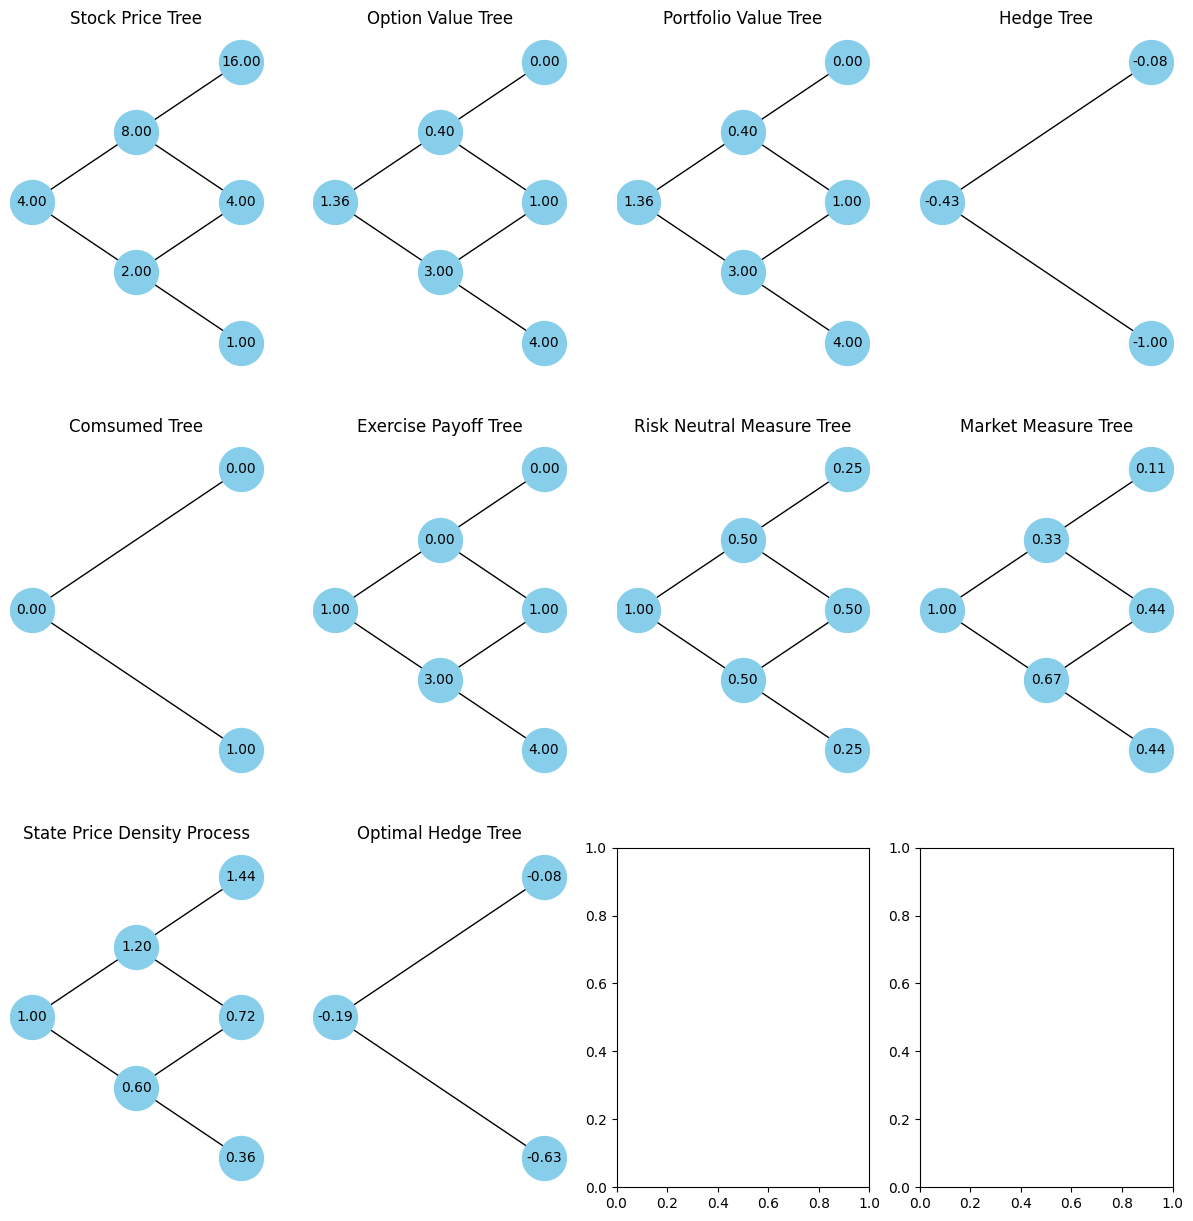

In [705]:
target = trees[0:]
col = 4
row = math.ceil(len(target) / col) if col > 1 else len(target)
fig, axs = plt.subplots(row, col, figsize=(15,15))
for ax, (tree, name) in zip(axs.flat, target):
    draw_binary_tree(tree, name, ax)
plt.show()